# Gravity Survey for Tunnel Detection
------------
* Due date: October 8, 2025

## Objectives

Our objectives are:
* Design and perform a surface gravity survey to detect the underground steam tunnel in front of the Green Center.


## Background
### Tunnels

In previous labs you have modeled the tunnels, the approximate range of gravity anomalies was between 30-80 microGal


## Task
Broadly your tasks involve three items:

### 1) Layout your survey
Setup and mark your survey locations on the ground.

### 2) Accurately measure the spatial locations
Using an appropriately accurate device, measure the station locations.

### 3) Measure Gravity
Using the gravimeters measure the anomaly of the tunnel. Remember to visit a base station often enough to accurately correct for instrument drift.

Afterwards, download the spatial and gravity data from the instruments.

# Lab 06 Writeup
### Lillian Hanson, Team 2, 10/08/2025

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from grav_utils.grav_interact import GravInteract
import math

### 2: Predicted Gravity Response:
Description of the predicted gravity response prior to survey that guided the data collection process.  A figure of the modeled/predicted data (using the code from last lab) with a descriptive caption.

In [2]:
### tunnel modeling code

dx=20
xmin = -200
xmax = 400

dx_me = 20 
xmin_me = -2500
xmax_me = 2500
obs_x3 = np.linspace(xmin_me, xmax_me, (xmax_me-xmin_me)//dx_me + 1)
obs_x4 = np.linspace(xmin, xmax, (xmax_me - xmin_me)//dx_me + 1)
obs_z4 = np.zeros_like(obs_x3)

obs4 = np.c_[obs_x4, obs_z4]

# tunnel lower
tunnel_l = np.array([
    [0, -407.5],
    [0, -248], 
    [170, -248],
    [170, -407.5]
])

# tunnel upper
tunnel_u = np.array([
    [148, -223], 
    [148, -27],
    [285, -27],
    [285, -223]
])

modeler4 = GravInteract(obs4)
modeler4.set_polygons([tunnel_l, tunnel_u])
modeler4

GravInteract(children=(FigureWidget({
    'data': [{'mode': 'lines',
              'type': 'scatter',
        …

The predicted gravity response is modeled above. This model includes the upper and the lower tunnels proportional to their distance below the surface. The prediction shows an increase in mGal readings above the tunnels, with extra growth where the tunnels superimpose each other.

### 3: Survey Predictions, Sketches
Description of the survey implemented in the field (survey length, number of stations, data separations, location relative to tunnels, etc.). A labeled graphic may be helpful to illustrate this.

The survey spanned 20 meters, 10 meters to each side from the center of the tunnel. It took ~160 minutes to complete. Group 2, the group I was in, denoted the survey placings with the center of the tunnel as 0, with values ranging to 10 m out on either side, the westward side (the side pointing to kafadar) being denoted as the negative axis. The graphic below shows the layout of the points where data was collected.  

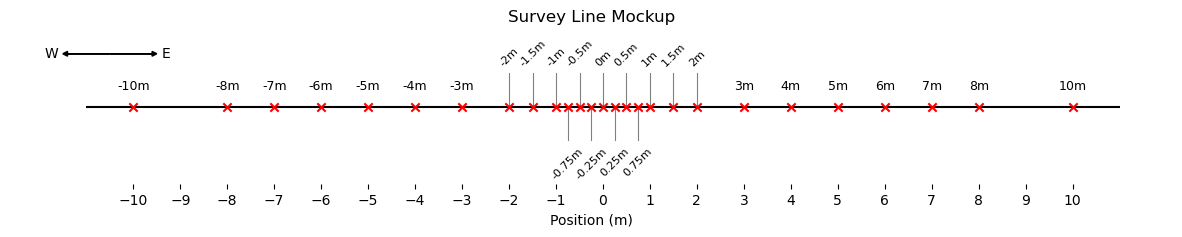

In [3]:
x_points = [-10, -8, -7, -6, -5, -4, -3, -2,
            -1.5, -1, -0.75, -0.5, -0.25, 0,
             0.25, 0.5, 0.75, 1, 1.5, 2,
             3, 4, 5, 6, 7, 8, 10]

plt.figure(figsize=(15, 2))
plt.hlines(0, min(x_points) - 1, max(x_points) + 1, colors='black')  # main line

# Plot 
plt.scatter(x_points, [0]*len(x_points), color='red', marker='x', zorder=3)

for x in x_points:
    # Points near zero 
    if -2 <= x <= 2:
        label_y = 0.35 if x % 0.5 == 0 else -0.35  
        plt.plot([x, x], [0, label_y], color='gray', lw=0.8, zorder=1)
        plt.text(x, label_y + (0.05 if label_y > 0 else -0.05),
                 f'{x}m', ha='center', va='bottom' if label_y > 0 else 'top',
                 fontsize=8, rotation=45)
    else:
        # Regular labels
        plt.text(x, 0.15, f'{x}m', ha='center', va='bottom', fontsize=9)

compass_x = min(x_points) - 0.5
compass_y = 0.55

plt.arrow(compass_x, compass_y, 1, 0, head_width=0.05, head_length=0.1,
          fc='black', ec='black', length_includes_head=True, zorder=4)
plt.arrow(compass_x, compass_y, -1, 0, head_width=0.05, head_length=0.1,
          fc='black', ec='black', length_includes_head=True, zorder=4)

plt.text(compass_x + 1.1, compass_y, 'E', ha='left', va='center', fontsize=10)
plt.text(compass_x - 1.1, compass_y, 'W', ha='right', va='center', fontsize=10)

# Styling
plt.yticks([])
plt.xticks(range(-10, 11, 1))
plt.xlabel('Position (m)')
plt.title('Survey Line Mockup')
plt.grid(False)
plt.box(False)
plt.ylim(-0.8, 0.8)

plt.show()

In [4]:
loc_data = pd.read_csv('data/grp2/grp2-lab6.csv')

In [5]:
locdf = loc_data
loccols = ['STATION', 'Northing', 'Easting', 'ELEV', 'Notes']
locdf.columns = loccols[:len(locdf.columns)]

for col in ['Northing', 'Easting', 'ELEV']:
    if col in locdf.columns:
        locdf[col] = pd.to_numeric(locdf[col], errors = 'coerce')
locdf = locdf.drop(index = 15)

reorder = locdf.iloc[33:34]
locdf = locdf.drop(index = 34)
locdf_top = locdf.iloc[:24]
locdf_bottom = locdf.iloc[24:]

locdf = pd.concat([locdf_top, reorder, locdf_bottom]).reset_index(drop=True)

Text(0.5, 1.0, 'Data Collection Locations')

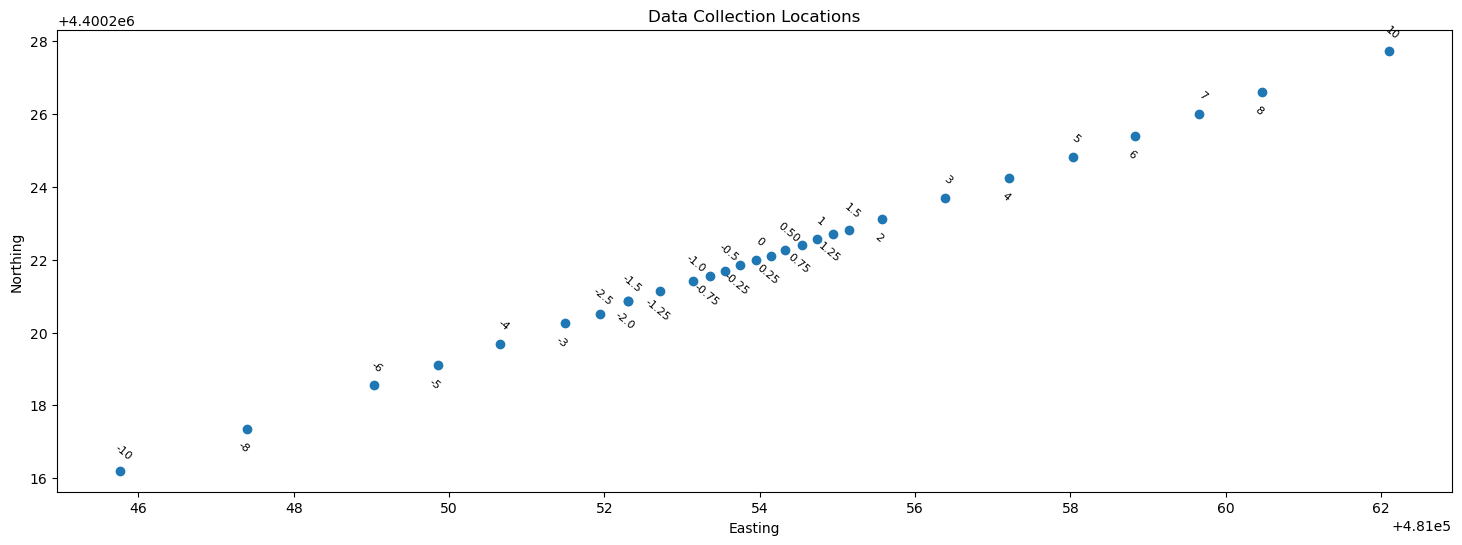

In [6]:
plotdf = locdf[pd.to_numeric(locdf['STATION'], errors='coerce').notna()]


plt.figure(figsize=(18, 6))
plt.scatter(x = plotdf['Easting'], y = plotdf['Northing'])
plt.xlabel('Easting')
plt.ylabel('Northing')

for i, label in enumerate(plotdf['STATION']):
    # alternate label position
    if i % 2 == 0:
        va = 'bottom'
        y_offset = 0.4  # small shift upward
        angle = -40
    else:
        va = 'top'
        y_offset = -0.4  # small shift downward
    
    plt.text(
        plotdf['Easting'].iloc[i],
        plotdf['Northing'].iloc[i] + y_offset,
        str(label),
        fontsize=8,
        ha='center',
        va=va,
        rotation = angle,
        rotation_mode='anchor'
    )
    
plt.title('Data Collection Locations')

#### Northing/Easting locations of the data collection locations, with the same station names as the line plot above.

### 4: Data Collected
Raw data with times (including base station) and standard deviations, as well as processed (drift and free-air corrected) field data you would use for interpretation.  
    Please include the following (where you should be including captions for each figure):
    * Plot of raw data (with SD error bars)
    * Plot of drift and free-air corrected data (with SD error bars)
    * Plot of drift, free-air, and simple Bouguer corrected data (with SD error bars)

In [7]:
column_names = [
    "LINE","STATION","ALT","GRAV","SD","TILTX","TILTY","TEMP","TIDE",
    "DUR","REJ","TIME","DEC_TIME_DATE","TERRAIN","DATE"
]

dfcg5 = pd.read_csv('data/grp2/CG5-2.TXT', sep=r'\s+', skiprows=52, header=None, names=column_names)

# Group by station and compute statistics
df_station = (
    dfcg5.groupby('STATION')
    .agg(
        GRAV_mean=('GRAV', 'mean'),
        SD=('GRAV', 'std'),
        n_per_station=('GRAV', 'count')
    )
    .reset_index()
)

# Compute standard error of the mean (SEM)
df_station['SEM'] = df_station['SD'] / np.sqrt(df_station['n_per_station'])


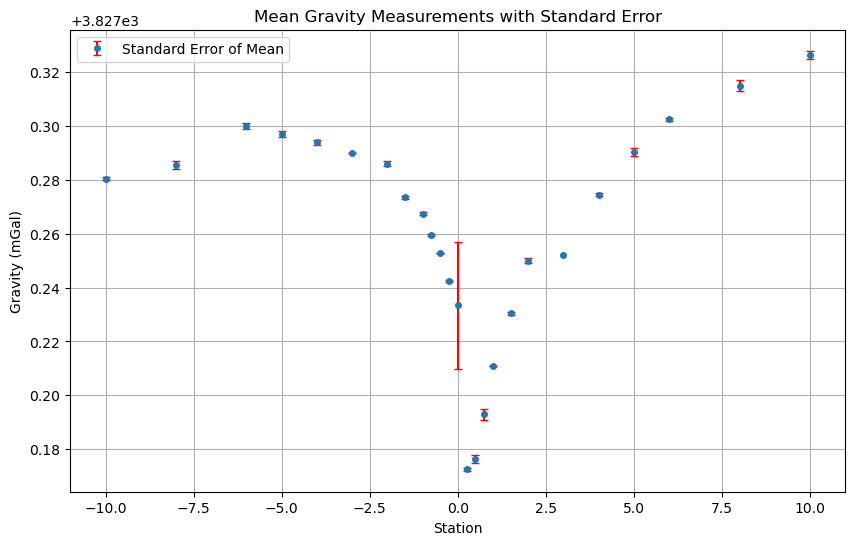

In [8]:
# Plot GRAV vs STATION with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(
    df_station['STATION'],
    df_station['GRAV_mean'],
    yerr=df_station['SEM'],
    fmt='o',
    ecolor='red',
    capsize=3,
    markersize=4,
    label='Standard Error of Mean'
)

plt.xlabel('Station')
plt.ylabel('Gravity (mGal)')
plt.title('Mean Gravity Measurements with Standard Error')
plt.legend()
plt.grid(True)
plt.show()

#### Raw Gravity Measurements (above)

In [51]:
# clean columns
dfcg5['STATION'] = dfcg5['STATION'].astype(str).str.strip()
locdf['STATION'] = locdf['STATION'].astype(str).str.strip()

dfcg5['STATION_NUM'] = pd.to_numeric(dfcg5['STATION'], errors='coerce')
locdf['STATION_NUM'] = pd.to_numeric(locdf['STATION'], errors='coerce')

# merge data frames
df = pd.merge(dfcg5, locdf[['STATION_NUM', 'Northing', 'Easting', 'ELEV']],
              on='STATION_NUM', how='left')

df = df[['STATION_NUM', 'GRAV', 'Northing', 'Easting', 'TIME', 'ELEV', 'SD']]
df = df.sort_values('STATION_NUM')

df_station_num = (
    df.groupby('STATION_NUM')
    .agg(
        GRAV_mean=('GRAV', 'mean'),
        SD=('GRAV', 'std'),
        n_per_station=('GRAV', 'count')
    )
    .reset_index()
)
# Compute standard error of the mean (SEM)
df_station_num['SEM'] = df_station['SD'] / np.sqrt(df_station['n_per_station'])

df = df.merge(df_station_num[['STATION_NUM', 'SEM']], on='STATION_NUM', how='left')

# masks
is_base = (df['STATION_NUM'] == 0.00)
is_station = (df['STATION_NUM'] != 0.00)

# indices
base_inds = np.where(is_base)[0]
station_inds = np.where(is_station)[0]


times = pd.to_datetime(df['TIME'], format='%H:%M:%S')
height = df['ELEV']
grav = df['GRAV']

In [52]:
# drift correction
# Linear drift model
g_drift = np.interp(times, times[base_inds], grav[base_inds])

In [53]:
# free air correction
g_obs = df['GRAV']
g_fa = -0.3086 * height

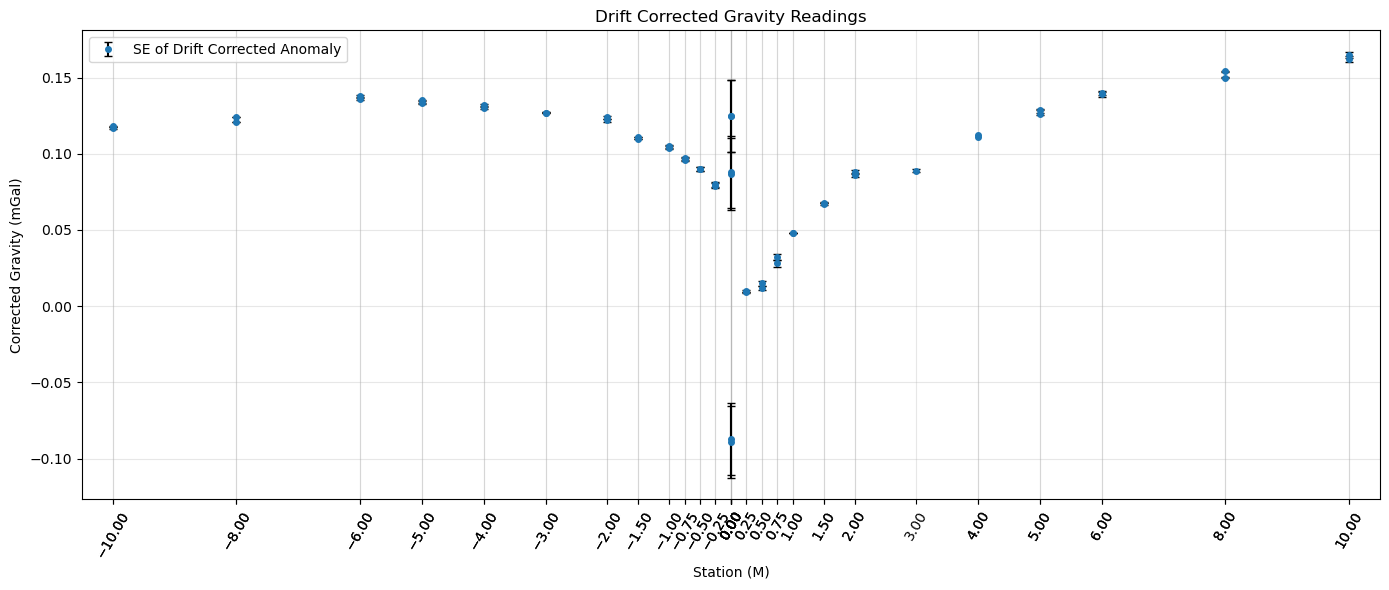

In [56]:
# plot corrected gravity
plt.figure(figsize=(14, 6))
plt.errorbar(
    df['STATION_NUM'], 
    (g_obs - g_drift),
    yerr=df['SEM'],
    fmt='o', ecolor='Black', capsize=3, markersize=4, label='SE of Drift Corrected Anomaly'
)

plt.xticks(df['STATION_NUM'], rotation=60)

plt.xlim(df['STATION_NUM'].min() - 0.5, df['STATION_NUM'].max() + 0.5)

plt.xlabel('Station (M)')
plt.ylabel('Corrected Gravity (mGal)')
plt.title('Drift Corrected Gravity Readings')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

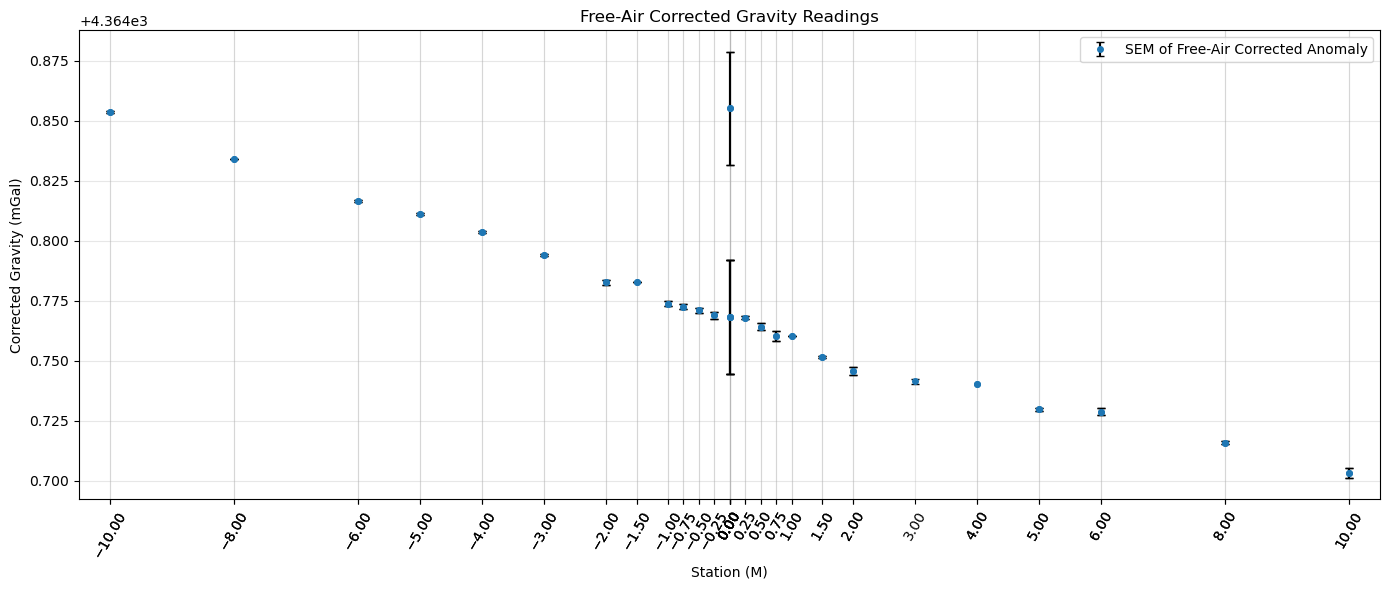

In [57]:
# plot corrected gravity

plt.figure(figsize=(14, 6))
plt.errorbar(
    df['STATION_NUM'], 
    (g_drift + 0.3086*height),
    yerr=df['SEM'],
    fmt='o', ecolor='Black', capsize=3, markersize=4, label='SEM of Free-Air Corrected Anomaly'
)

plt.xticks(df['STATION_NUM'], rotation=60)

plt.xlim(df['STATION_NUM'].min() - 0.5, df['STATION_NUM'].max() + 0.5)

plt.xlabel('Station (M)')
plt.ylabel('Corrected Gravity (mGal)')
plt.title('Free-Air Corrected Gravity Readings')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

#### Drift Corrected Gravity Readings (above)

In [68]:
# simple bouger correction

g_boog = 0.1119 * (g_obs / df['ELEV']) * height

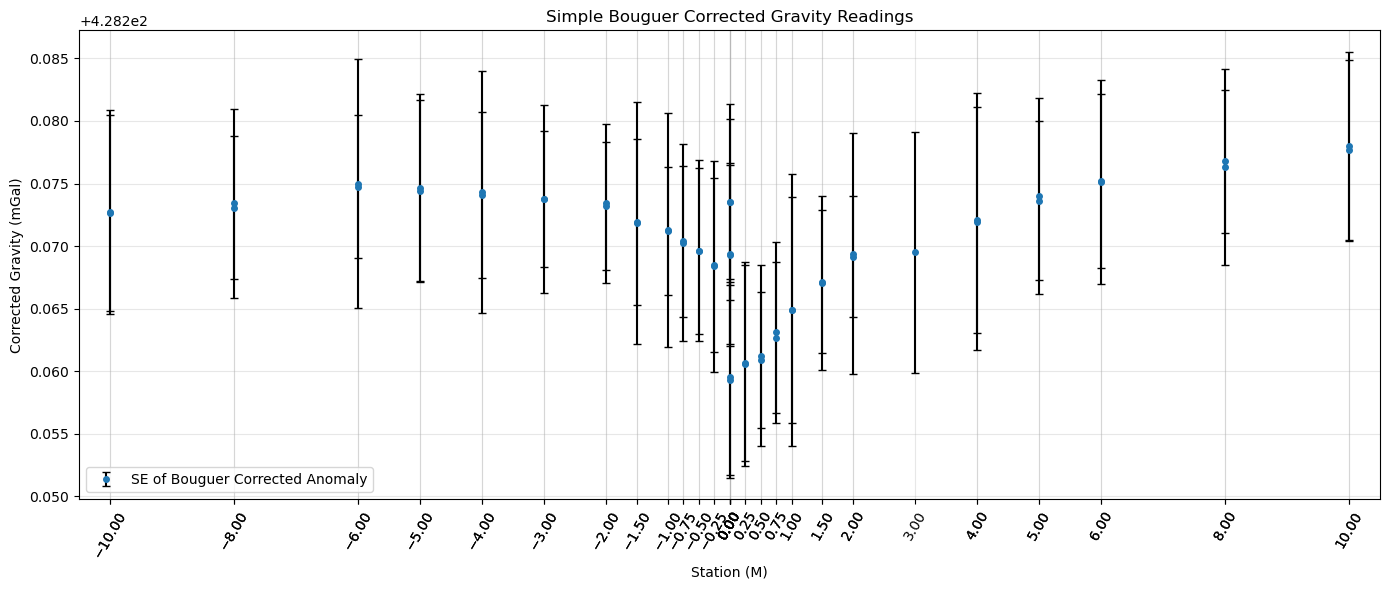

In [69]:
# plot corrected gravity
plt.figure(figsize=(14, 6))
plt.errorbar(
    df['STATION_NUM'], 
    g_boog,
    yerr=(df.get('SD') / math.sqrt(len('STATION_NUM'))),
    fmt='o', ecolor='Black', capsize=3, markersize=4, label='SE of Bouguer Corrected Anomaly'
)

plt.xticks(df['STATION_NUM'], rotation=60)

plt.xlim(df['STATION_NUM'].min() - 0.5, df['STATION_NUM'].max() + 0.5)

plt.xlabel('Station (M)')
plt.ylabel('Corrected Gravity (mGal)')
plt.title('Simple Bouguer Corrected Gravity Readings')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

#### Simple Bouguer Corrected Gravity Readings (above)

In [70]:
# full corrected value
grav = g_obs - g_drift - g_fa - g_boog

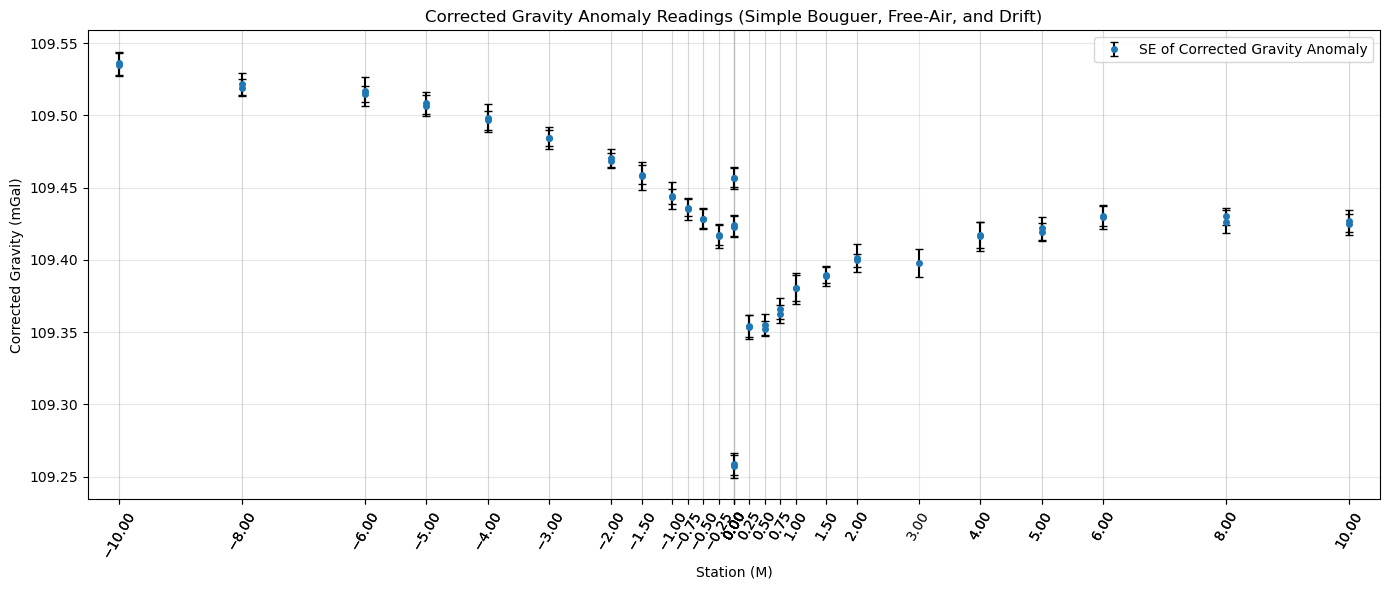

In [71]:
# plot corrected gravity
plt.figure(figsize=(14, 6))
plt.errorbar(
    df['STATION_NUM'], 
    grav,
    yerr=(df.get('SD') / math.sqrt(len('STATION_NUM'))),
    fmt='o', ecolor='Black', capsize=3, markersize=4, label='SE of Corrected Gravity Anomaly'
)

plt.xticks(df['STATION_NUM'], rotation=60)

plt.xlim(df['STATION_NUM'].min() - 0.5, df['STATION_NUM'].max() + 0.5)

plt.xlabel('Station (M)')
plt.ylabel('Corrected Gravity (mGal)')
plt.title('Corrected Gravity Anomaly Readings (Simple Bouguer, Free-Air, and Drift)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [73]:
df.head(20)

,STATION_NUM,GRAV,Northing,Easting,TIME,ELEV,SD,SEM
0,-10.00,3827.281,4400216.203,481045.768,15:45:12,1742.355,0.027,0.0005
1,-10.00,3827.280,4400216.203,481045.768,15:46:28,1742.355,0.026,0.0005
2,-8.00,3827.287,4400217.361,481047.392,15:42:59,1742.292,0.025,0.0000
3,-8.00,3827.284,4400217.361,481047.392,15:41:43,1742.292,0.019,0.0000
4,-6.00,3827.301,4400218.545,481049.027,15:36:41,1742.235,0.033,0.0005
5,-6.00,3827.299,4400218.545,481049.027,15:37:57,1742.235,0.019,0.0005
6,-5.00,3827.298,4400219.109,481049.857,15:33:28,1742.217,0.025,0.0005
7,-5.00,3827.296,4400219.109,481049.857,15:34:44,1742.217,0.024,0.0005
8,-4.00,3827.295,4400219.698,481050.661,15:30:10,1742.193,0.032,0.0005
9,-4.00,3827.293,4400219.698,481050.661,15:31:26,1742.193,0.022,0.0005


In [74]:
# Convert TIME column to datetime so we can sort/use min/max
df['TIME'] = pd.to_datetime(df['TIME'], format="%H:%M:%S")

# Group by station number
stats = df.groupby('STATION_NUM').agg(
    n=('GRAV', 'count'),
    SD=('GRAV', 'std'),
    SEM=('GRAV', lambda x: x.std() / np.sqrt(len(x))),
    First_Time=('TIME', 'min'),
    Last_Time=('TIME', 'max')
).reset_index()

# Add a text column describing how SD/SEM were computed
stats['Method'] = stats.apply(
    lambda row: f"SD = std of {row['n']} repeats; SEM = SD/sqrt(n)", axis=1
)

# Rename columns for presentation
stats = stats.rename(columns={
    'STATION_NUM': 'Station',
    'SD': 'SD (mGal)',
    'SEM': 'SEM (mGal)'
})

stats

,Station,n,SD (mGal),SEM (mGal),First_Time,Last_Time,Method
0,-10.00,2,0.000707,0.000500,1900-01-01 15:45:12,1900-01-01 15:46:28,SD = std of 2 repeats; SEM = SD/sqrt(n)
1,-8.00,2,0.002121,0.001500,1900-01-01 15:41:43,1900-01-01 15:42:59,SD = std of 2 repeats; SEM = SD/sqrt(n)
2,-6.00,2,0.001414,0.001000,1900-01-01 15:36:41,1900-01-01 15:37:57,SD = std of 2 repeats; SEM = SD/sqrt(n)
3,-5.00,2,0.001414,0.001000,1900-01-01 15:33:28,1900-01-01 15:34:44,SD = std of 2 repeats; SEM = SD/sqrt(n)
4,-4.00,2,0.001414,0.001000,1900-01-01 15:30:10,1900-01-01 15:31:26,SD = std of 2 repeats; SEM = SD/sqrt(n)
5,-3.00,2,0.000000,0.000000,1900-01-01 15:26:58,1900-01-01 15:28:14,SD = std of 2 repeats; SEM = SD/sqrt(n)
6,-2.00,2,0.001414,0.001000,1900-01-01 15:22:12,1900-01-01 15:23:28,SD = std of 2 repeats; SEM = SD/sqrt(n)
7,-1.50,2,0.000707,0.000500,1900-01-01 15:18:52,1900-01-01 15:20:08,SD = std of 2 repeats; SEM = SD/sqrt(n)
8,-1.00,2,0.000707,0.000500,1900-01-01 15:15:25,1900-01-01 15:16:41,SD = std of 2 repeats; SEM = SD/sqrt(n)
9,-0.75,2,0.000707,0.000500,1900-01-01 15:12:02,1900-01-01 15:13:18,SD = std of 2 repeats; SEM = SD/sqrt(n)


#### Corrected Gravity Anomaly Readings (above)

### 5: Interpretations
A qualitative interpretation of field data (based on what you see visually in the measured gravity data, and relative to the forward models you performed in the previous labs).  
Address the following:
- Compare your response to the models of the tunnels generated in the previous lab.
- How does your model(s) compare to the data you collected?
- If any discrepancies exist, why?
- What parameters would you like more information about?

- The difference in shapes/values on either side of the tunnel region makes sense due to the superposition principles discussed in the previous lab. 
- My modeled response has a shape that is roughly inverse of the shape of my digitally modeled tunnel's gravity anomaly.
- Discrepancies exist due to a number of factors. One of these discrepancies is the larger x and y tilt values on my outlying values, which means that the CG-5 was not leveled perfectly. Another discrepancy may occur due to the simplification of the terrain correction. 
- I would like more information about a more complex terrain correction. Where would I get the data to perform those integrals? 

### 6: Improvements
 Very brief recommendation on how you would improve the survey if you had the opportunity to re-collect data over the tunnel.

If I had the opportunity to collect more data over the tunnel, the first change I would make would be using tape instead of chalk to mark survey locations so the locations couldn't be smudged or lost. I would also try to be more time-efficient for the sake of creating more closed loops in the survey to improve my accuracy. I would also like to take more measurements, perhaps every half meter along the entire line.

### 7: Adjustments
Assuming your geometry of the tunnels is correct, how would you adjust the density contrast of your model?

I would adjust the density contrast of the tunnel areas to be 0.00 $g/cm^3$ and the surrounding Earth to be 2.5 $g/cm^3$. This would give an overall density contrast of -2.5$g/cm^3$.